## Quora question pair similarity classification

### GloVe stands for “`Global Vectors`”

* GloVe method is built on an important idea,

You can derive **`semantic relationships`** between words from the co-occurrence matrix.

In [ ]:
!pip install distance
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/train.csv')

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.shape

(404290, 6)

In [ ]:
df = df.dropna(how="any").reset_index(drop=True)

In [ ]:
df.shape

(404287, 6)

<Axes: xlabel='is_duplicate'>

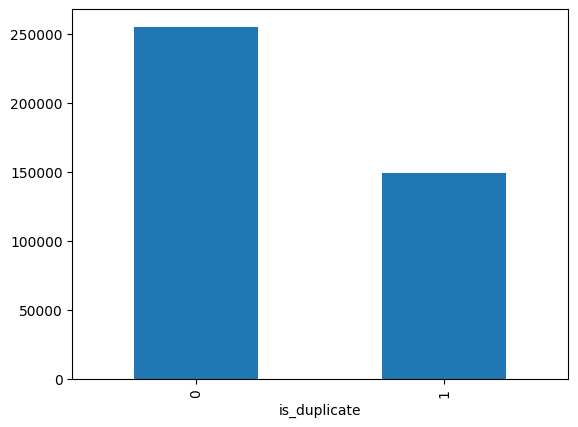

In [ ]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
df['is_duplicate'].value_counts(normalize = True)

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

- Similar question pair - 36.92%

- Non-Similar question pair - 63.07%

## Number of Unique Questions

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


Total number of  Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157



## checking whether there are any repeated pair of questions

In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### Data cleaning

In [27]:
import nltk
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [19]:
#Cleaning
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

from string import punctuation
stop_words = stopwords.words('english')

def clean(text, stem_words=True):

    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()
    
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
       # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

In [20]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [21]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


## Feature Engineering

* Feature engineering is a way where we come up with meaningful features from the already existing features. There is a lot of scope for feature engineering in this project. 
* Let's explore and find ways in which we can find the similarity between two questions.

In [22]:
import gensim
import smart_open
from gensim.models import Word2Vec

* For several text similarity calculation we need to convert the texts to the representable embedding vectors on which distance could be calculated.
* We could use Gensim Google Word2Vec which embeds each word to 300 dimension vector.
* We could also create our own embedding. For simplicity we use Gensim Word2Vec which is based on huge corpus of text. Let's load it !!

In [23]:
import gensim
import gensim.downloader as api

print(gensim.__version__)

print(list(gensim.downloader.info()['models'].keys()))

4.3.1
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [24]:
wv = api.load('glove-wiki-gigaword-300')

[=================================================-] 100.0% 375.9/376.1MB downloaded

In [25]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(wv[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [28]:
from tqdm import tqdm_notebook #for parallel processing

question1_vectors = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q) #function call for each question 1
    
question2_vectors  = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q) #function call for each question 2

<ipython-input-28-39866f9955f8>:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

<ipython-input-25-2f2aacb9582d>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-28-39866f9955f8>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

### Cosine distance

It is the compliment of the cosine similarity. Cosine similarity finds the angle between two text vectors in higher dimensional space. If cos(theta) is small then the cosine distance is large and vice-versa.
* Hence Inversly proportional. 
           Cosine distance = 1 - Cosine similarity

### Mahattan or City-block distance

Manhattan Distance is preferred over the Euclidean distance metric as the dimension of the data increases. This occurs due to something known as the ‘curse of dimensionality’.

### Jaccard distance

It is defined as size of intersection divided by size of union of two sets.

### Fuzz_ratio

It is a ratio function that computes the standard Levenshtein distance similarity ratio between two sequences.

### Fuzz_partial_ratio

This function allows us to perform substring matching. This works by taking the shortest string and matching it with all substrings that are of the same length.

### Fuzz_token_sort_ratio

This function sorts the strings alphabetically and then joins them together. Then, the fuzz.ratio() is calculated. This can come in handy when the strings you are comparing are the same in spelling but are not in the same order.

### Fuzz_token_set_ratio

The token_set_ratio() function is similar to the token_sort_ratio() function above, except it takes out the common tokens before calculating the fuzz.ratio() between the new strings.
    This function is the most helpful when applied to a set of strings with a significant difference in lengths.

In [ ]:
import distance
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

from fuzzywuzzy import fuzz


### Let's apply all these feature engineering techniques on the data

In [30]:
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [31]:
# Fuzzy
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [33]:
# Distances
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:622: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1157: RuntimeWarning:

invalid value encountered in double_scalars



In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,80,67,67,0.190421,8.554435,1.0,148.870227,0.617124,0.276275,0.372139
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,29,28,25,0.546846,14.241201,1.0,192.699511,1.045798,0.478082,0.667696
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,71,63,48,0.293943,10.575400,1.0,167.870487,0.766738,0.351893,0.471646


In [35]:
df.to_csv('quora_df.csv',index=False)

In [37]:
df.drop(['id','qid1','qid2','question1','question2'],axis = 1,inplace = True)

In [38]:
df.head(2)

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,0,41,77,3,66,85,100,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816


In [39]:
df.shape

(404287, 17)

In [40]:
df.dropna(axis = 0,inplace = True)

In [42]:
df = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','jaccard_distance','euclidean_distance',
                'minkowski_distance','is_duplicate']] # Reanrrange the features

### Segregating the data to input and output

In [43]:
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

In [44]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### segregating the Numerical features of Train Data

In [46]:
X_train_num = X_train.select_dtypes(include = ['int64', 'float64']) 

In [47]:
# scaling the numerical features
from sklearn.preprocessing import StandardScaler

Std_scaler = StandardScaler()

X_train_trns = pd.DataFrame(Std_scaler.fit_transform(X_train_num),
                                     columns = X_train_num.columns,
                                     index = X_train_num.index)
X_train_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
165624,-0.012271,0.846044,1.120750,0.711166,0.358029,0.980195,0.673491,-0.485724,-0.746500,-0.661773,-0.699743,-0.730799
253997,-0.960799,-0.593752,-1.417369,-1.070557,-1.248901,-2.043991,-1.766669,0.508652,0.529589,0.699414,0.700964,0.721691
153684,-0.960799,-0.429204,-1.417369,-1.344668,-1.870938,-2.450224,-2.205898,1.658173,3.510634,2.594425,2.524759,2.417193
59494,0.574913,0.023303,0.105503,-0.750760,-1.145228,-0.735015,-0.546589,0.065309,-0.331194,-0.104540,-0.127095,-0.146956
108477,-0.599455,0.640359,0.613127,0.025888,0.409865,0.754509,-0.204967,-0.169741,-0.466803,-0.275858,-0.293190,-0.330262


### segregating the Numerical features of Test Data

In [48]:
X_test_num = X_test.select_dtypes(include = ['int64', 'float64']) 

In [49]:
X_test_trns = pd.DataFrame(Std_scaler.transform(X_test_num),
                                    columns = X_test_num.columns,
                                    index = X_test_num.index)
X_test_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
344164,-0.554287,-0.634889,-0.909745,-0.705075,-1.093391,-0.780152,-0.400179,0.192571,0.190373,0.360648,0.408457,0.421945
98151,-0.102607,2.491525,-0.909745,-0.933501,-0.575027,-1.637757,-1.473850,1.276017,1.433280,1.403984,1.359152,1.278967
36619,0.845921,0.558085,1.120750,-0.065482,-0.471354,0.980195,1.112720,0.363171,0.349978,0.616412,0.550219,0.474132
200148,0.213569,1.010592,0.613127,-0.156853,-0.678700,0.258001,0.234262,0.222833,0.106766,0.346993,0.330799,0.299557
268056,0.710417,-0.922848,-0.402121,-0.568020,-0.367681,0.167727,-0.644195,0.419602,0.221089,0.411576,0.436371,0.449013


# Model Building

### Logistic Regression

In [50]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression()
cls.fit(X_train_trns, y_train)

# prediction on train
y_train_pred = cls.predict(X_train_trns)


print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))


# prediction on test
y_test_pred = cls.predict(X_test_trns)


print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---------- Prediction on train ----------
[[135408  43042]
 [ 46923  57330]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75    178450
           1       0.57      0.55      0.56    104253

    accuracy                           0.68    282703
   macro avg       0.66      0.65      0.66    282703
weighted avg       0.68      0.68      0.68    282703

---------- Prediction on test ----------
[[57860 18314]
 [20476 24509]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     76174
           1       0.57      0.54      0.56     44985

    accuracy                           0.68    121159
   macro avg       0.66      0.65      0.65    121159
weighted avg       0.68      0.68      0.68    121159



### GridSearch CV

In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier

tuned_parameters = [{'alpha':[x for x in range(1,10)]}]

clf = GridSearchCV(
    estimator=RidgeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trns, y_train)

print("Best parameters set found on train set:")
print(clf.best_params_)
print(clf.best_estimator_)

y_p = clf.predict(X_test_trns)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on train set:
{'alpha': 1}
RidgeClassifier(alpha=1)


### Evaluation Metrics

In [52]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [53]:
# Evaluating the model using the Evaluation metrics
print(f1_score(y_test, y_p)) 
print(classification_report(y_test, y_p))

0.5420928588263021
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     76174
           1       0.58      0.51      0.54     44985

    accuracy                           0.68    121159
   macro avg       0.65      0.64      0.65    121159
weighted avg       0.67      0.68      0.67    121159



### AdaBoost Classifier

In [54]:
from sklearn.ensemble import AdaBoostClassifier

cls1 = AdaBoostClassifier()
cls1.fit(X_train_trns, y_train)

# prediction on train
y_train_pred1 = cls1.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred1))
print(classification_report(y_train, y_train_pred1))

# prediction on test
y_test_pred1 = cls1.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred1))
print(classification_report(y_test, y_test_pred1))

---------- Prediction on train ----------
[[133879  44571]
 [ 34316  69937]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77    178450
           1       0.61      0.67      0.64    104253

    accuracy                           0.72    282703
   macro avg       0.70      0.71      0.71    282703
weighted avg       0.73      0.72      0.72    282703

---------- Prediction on test ----------
[[57243 18931]
 [14759 30226]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     76174
           1       0.61      0.67      0.64     44985

    accuracy                           0.72    121159
   macro avg       0.70      0.71      0.71    121159
weighted avg       0.73      0.72      0.72    121159



### Gradient Boosting Classifier

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
cls2 = GradientBoostingClassifier()
cls2.fit(X_train_trns, y_train)

# prediction on train
y_train_pred2 = cls2.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))

# prediction on test
y_test_pred2 = cls2.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred2))
print(classification_report(y_test, y_test_pred2))

---------- Prediction on train ----------
[[132732  45718]
 [ 27886  76367]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78    178450
           1       0.63      0.73      0.67    104253

    accuracy                           0.74    282703
   macro avg       0.73      0.74      0.73    282703
weighted avg       0.75      0.74      0.74    282703

---------- Prediction on test ----------
[[56741 19433]
 [12169 32816]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     76174
           1       0.63      0.73      0.67     44985

    accuracy                           0.74    121159
   macro avg       0.73      0.74      0.73    121159
weighted avg       0.75      0.74      0.74    121159



### XGBoost Classifier

In [56]:
import xgboost as xgb
from xgboost import XGBClassifier
cls3 = XGBClassifier()
cls3.fit(X_train_trns, y_train)

# prediction on train
y_train_pred3 = cls3.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred3))
print(classification_report(y_train, y_train_pred3))

# prediction on test
y_test_pred3 = cls3.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred3))
print(classification_report(y_test, y_test_pred3))

---------- Prediction on train ----------
[[140844  37606]
 [ 25923  78330]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.82    178450
           1       0.68      0.75      0.71    104253

    accuracy                           0.78    282703
   macro avg       0.76      0.77      0.76    282703
weighted avg       0.78      0.78      0.78    282703

---------- Prediction on test ----------
[[59061 17113]
 [12545 32440]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     76174
           1       0.65      0.72      0.69     44985

    accuracy                           0.76    121159
   macro avg       0.74      0.75      0.74    121159
weighted avg       0.76      0.76      0.76    121159



## Stacking Classifier

In [57]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier(),
      'RC',RidgeClassifier(),
     'RF',RandomForestClassifier(),
     'GBDT',GradientBoostingClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=XGBClassifier())

stack_cls.fit(X_train_trns, y_train)


# Prediction on test data
y_test_pred4 = stack_cls.predict(X_test_trns)

print('-'*10,'on test','-'*10)
# Evaluation on test data
print(confusion_matrix(y_test, y_test_pred4))
print(classification_report(y_test, y_test_pred4))

---------- on test ----------
[[61229 14945]
 [19011 25974]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     76174
           1       0.63      0.58      0.60     44985

    accuracy                           0.72    121159
   macro avg       0.70      0.69      0.69    121159
weighted avg       0.72      0.72      0.72    121159



In [58]:
from pickle import dump

dump(cls, open(r"/content/drive/MyDrive/Quora\LR_cls.pkl", 'wb'))
dump(stack_cls, open(r"/content/drive/MyDrive/Quora\stack_cls.pkl", 'wb'))
dump(clf, open(r"/content/drive/MyDrive/Quora\LR_HYP.pkl", 'wb'))
dump(cls1, open(r"/content/drive/MyDrive/Quora\ADA_cls.pkl", 'wb'))
dump(cls2, open(r"/content/drive/MyDrive/Quora\GBDT_cls.pkl", 'wb'))
dump(cls3, open(r"/content/drive/MyDrive/Quora\XGB_cls.pkl", 'wb'))

In [2]:
quora_df = pd.read_csv(r"C:\Users\prave\Downloads\quora_df.csv")

In [6]:
quora_df.isna().sum()

id                                 0
qid1                               0
qid2                               0
question1                          6
question2                          1
is_duplicate                       0
len_q1                             0
len_q2                             0
common_words                       0
fuzz_ratio                         0
fuzz_partial_ratio                 0
fuzz_partial_token_set_ratio       0
fuzz_partial_token_sort_ratio      0
fuzz_token_set_ratio               0
fuzz_token_sort_ratio              0
cosine_distance                    0
cityblock_distance                 0
jaccard_distance                   0
canberra_distance                  0
euclidean_distance                 0
minkowski_distance                 0
braycurtis_distance              425
dtype: int64

## Experiment Tracking with mlflow

In [4]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

mlflow.autolog()
# Separating the input and output variables.
y = quora_df['is_duplicate'] 
X = quora_df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

# Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)

#Separating the numerical data from the train data
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

#Separating the numerical data from the test data
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

# Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train_num),
                                      columns= X_train_num.columns,
                                      index= X_train_num.index)

# Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)

# Training and Testing the data
classifier = GradientBoostingClassifier()
classifier.fit(X_train_transformed, y_train)
y_test_predicted = classifier.predict(X_test_transformed)
print('Mean accuracy score: ', metrics.accuracy_score(y_test, y_test_predicted))

2023/06/06 11:44:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/06 11:45:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/06 11:45:01 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2023/06/0

Mean accuracy score:  0.7381458853793069


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
mlflow.sklearn.autolog(max_tuning_runs=None)

with mlflow.start_run():
    tuned_parameters = [{'max_depth':[i for i in range(1, 51)]}]
    clf = GridSearchCV(
        estimator=GradientBoostingClassifier(), 
        param_grid=tuned_parameters, 
        scoring='accuracy',
        cv=5,
        return_train_score=True,
        verbose=1
    )
    clf.fit(X_train_transformed, y_train)
    # Disabling autologging
    mlflow.sklearn.autolog(disable=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [5]:
pwd/

'C:\\Users\\prave\\Data Science INN\\3_Internship'

## Link for Mlops 

http://127.0.0.1:5000/#/experiments/0?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All%20Runs&selectedColumns=attributes.%60Source%60,attributes.%60Models%60&isComparingRuns=false&compareRunCharts=

! 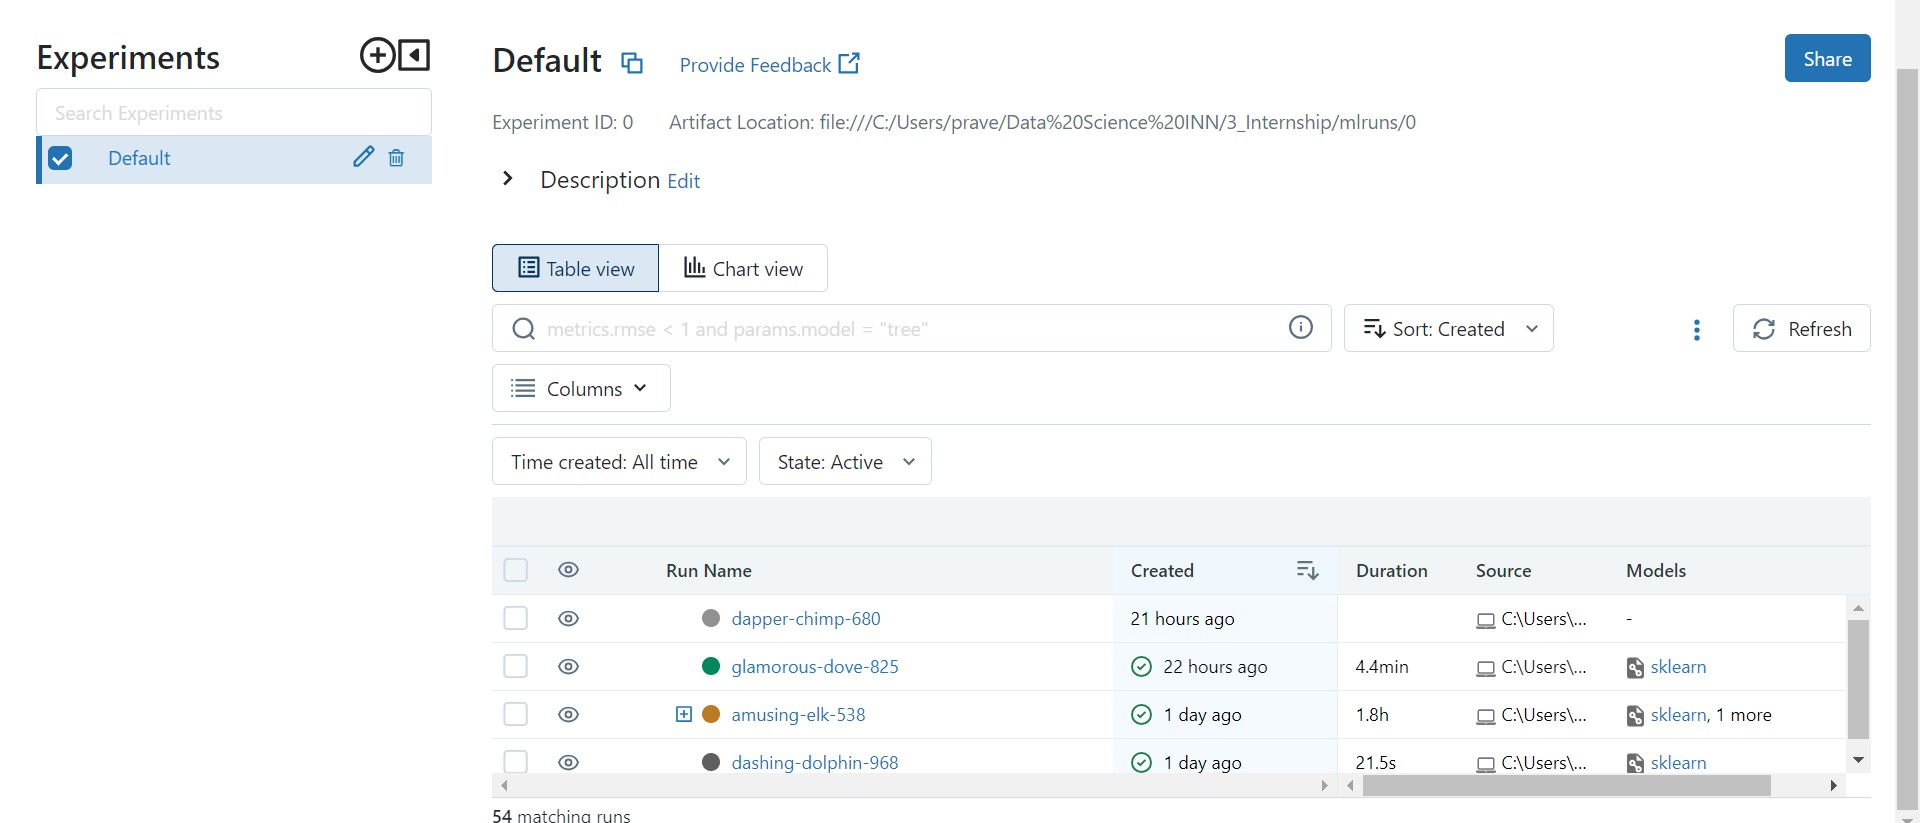

! 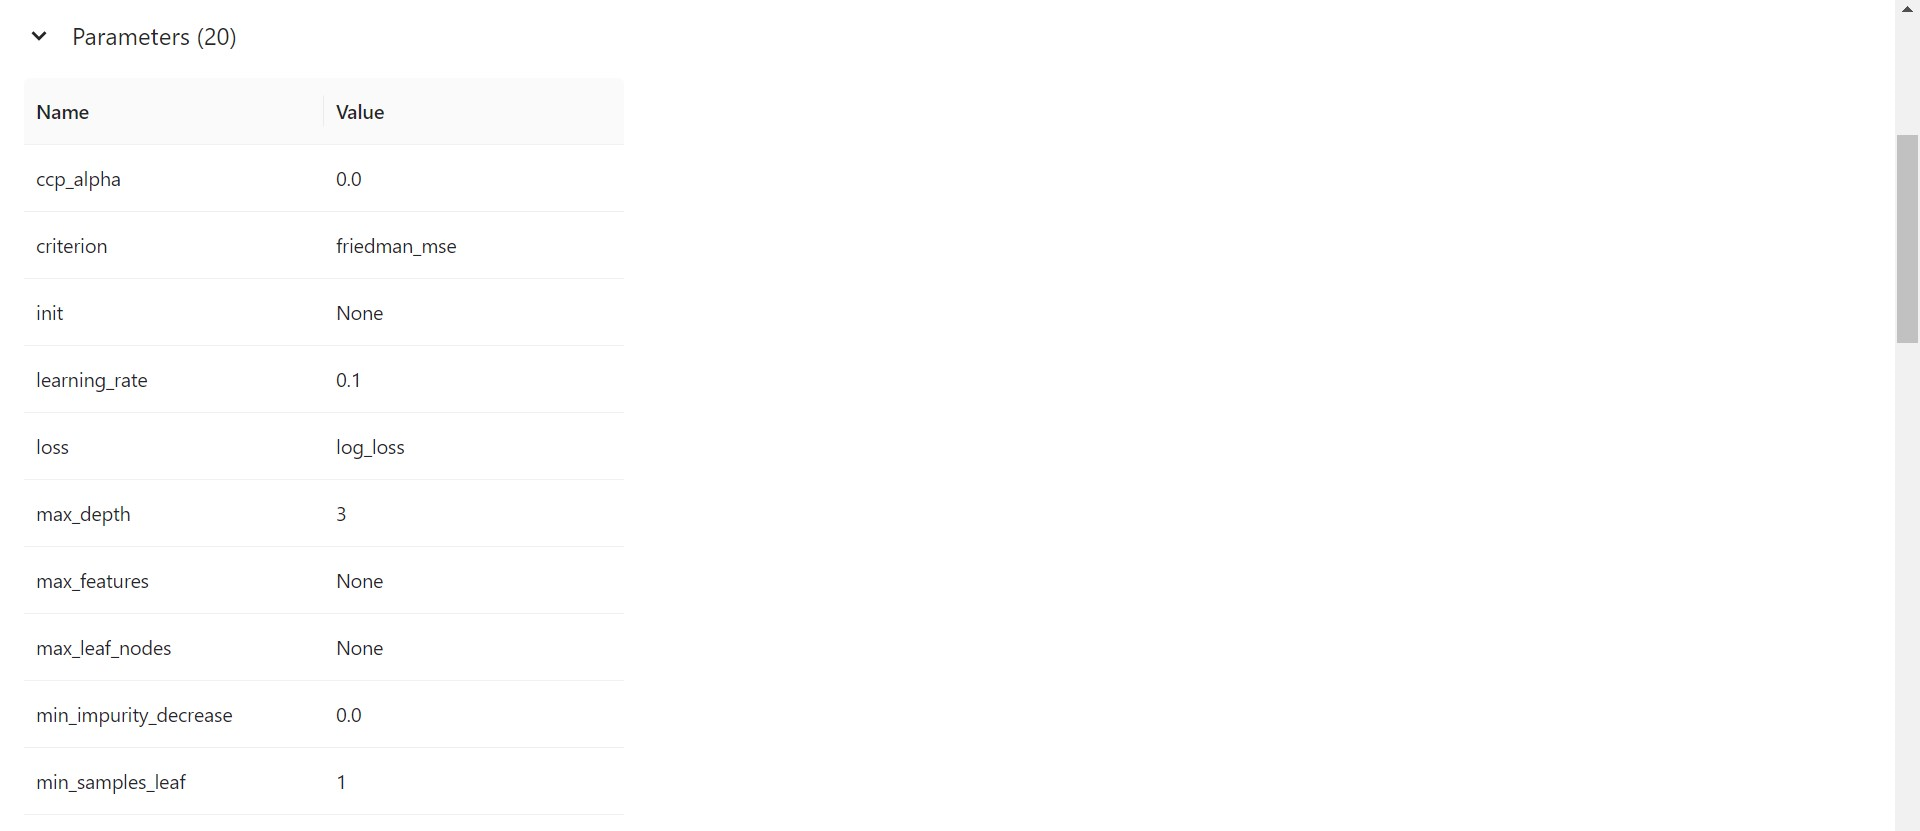

! 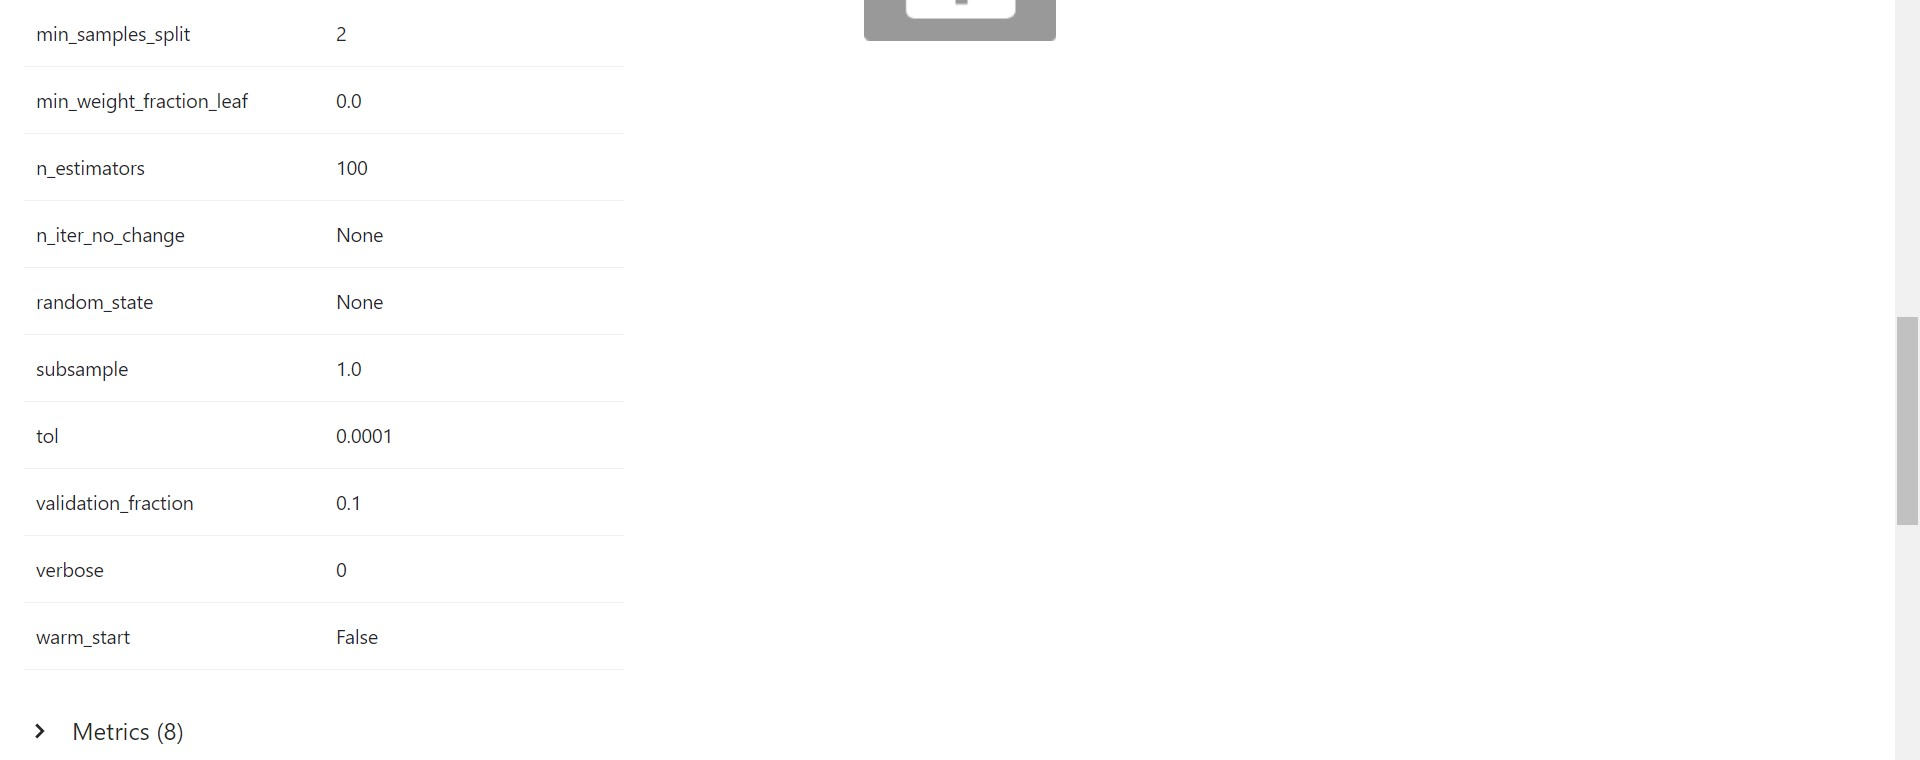

! 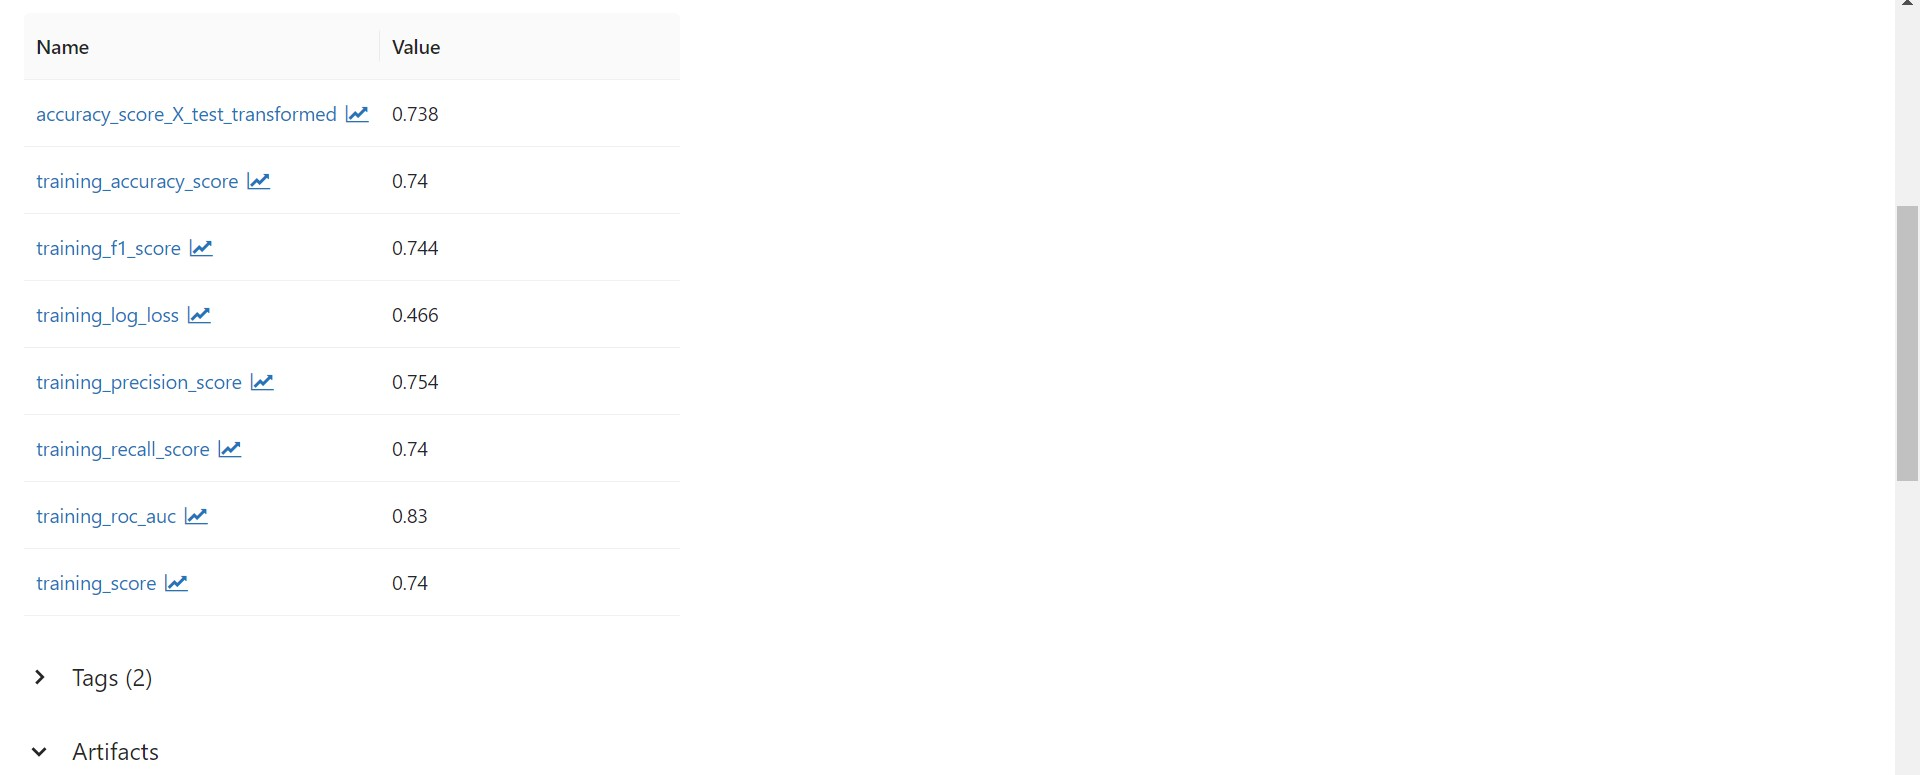

! 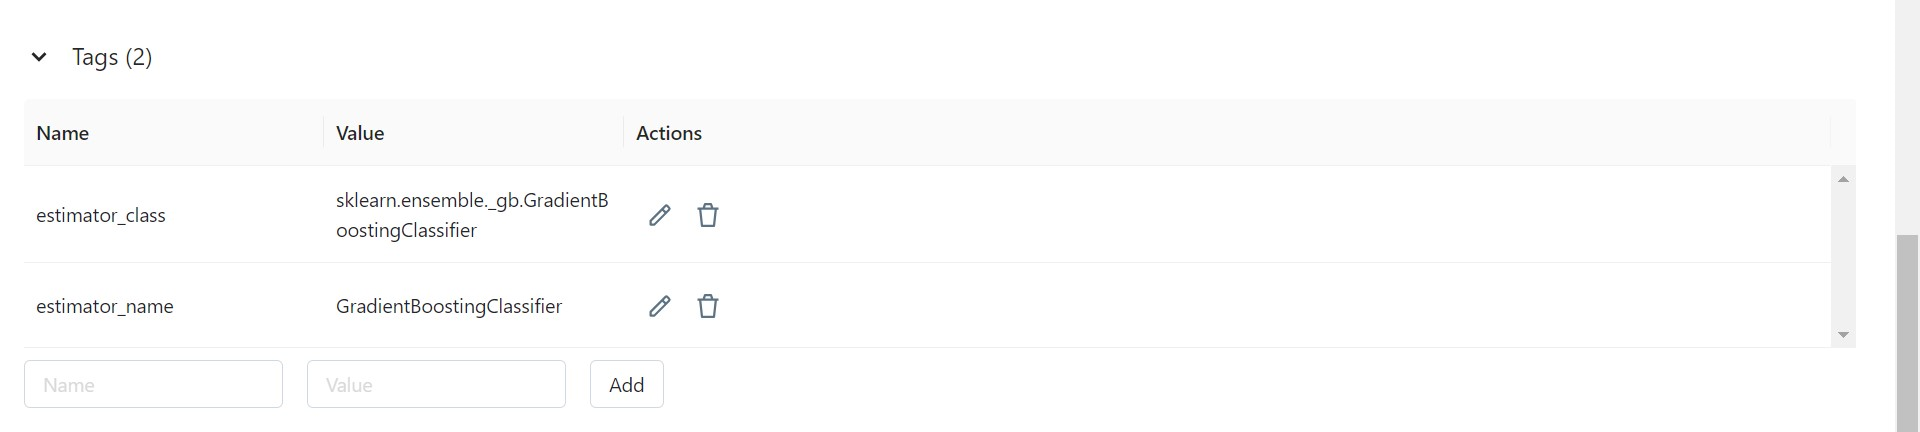

! 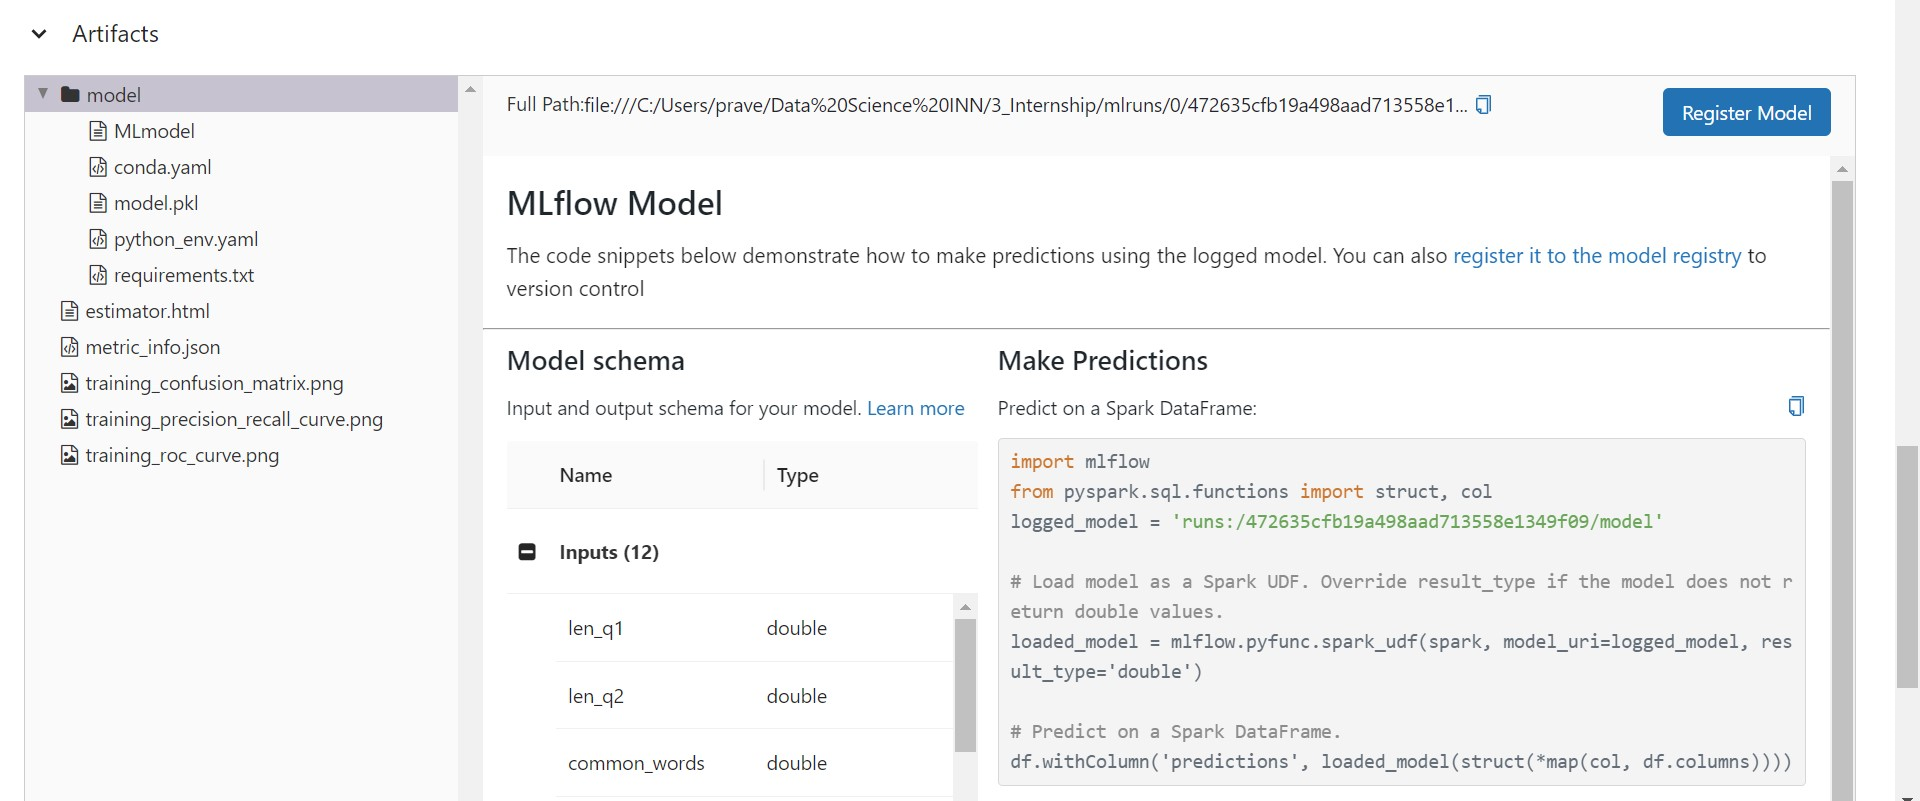